In [10]:
import pandas as pd
import pickle
import numpy as np
import torch
import os
import sys
import gc
import catboost

file = open('cat_cols.txt', 'rb')
cat_cols = pickle.load(file)
file.close()


# function to convert dtypes
def encode_cat(x):
    if isinstance(x, float):
        return str(x)
def dt_converter(dtype):
    if dtype == 'float64':
        return 'float16'
    elif dtype == 'int64':
        return 'int16'
    else:
        return 'object'

def mem_usage_gb(df):
    return round((df.memory_usage(deep=True).sum()/1073741824), 2)

def file_mem_usage_gb(file_name):
    return round((os.stat(file_name).st_size/1073741824), 2)

I pre-processed data in different file and saved to csv, now I only have to open it
but there is an issue with dtypes
beforehand I had dtypes_dict to convert float64 to float16 to reduce mem usage
now columns are named differently and I have to redo the conversion

In [11]:
train_data = pd.read_csv('prep_catboost_train.csv')
display(train_data.head())
print('DataFrame memory usage:', mem_usage_gb(train_data), 'GB    ', 'File size:', file_mem_usage_gb('prep_catboost_train.csv'), 'GB')

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.9336,0.024194,0.8687,0.9604,0.9346,0.010704,0.024440,0.001082,0.091500,...,1,13,O,1,0,NaN,0,13,6.0,1
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.9000,0.022097,0.8613,0.9290,0.8804,0.215200,0.199123,0.002224,0.567400,...,1,13,O,1,0,NaN,0,13,6.0,1
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.8784,0.028837,0.7980,0.9043,0.8810,0.004180,0.002759,0.000802,0.009705,...,1,13,R,1,0,NaN,0,13,6.0,1
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.5990,0.020082,0.5674,0.6235,0.6216,0.048860,0.088490,0.000660,0.268600,...,1,13,O,1,0,NaN,0,13,3.0,3
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.8916,0.042316,0.8050,0.9404,0.8720,0.004642,0.002883,0.000030,0.008680,...,1,13,O,1,13,1.0,1,13,6.0,1


DataFrame memory usage: 3.23 GB     File size: 3.47 GB


dataset is too big should be around 1 GB got 3.23 GB
This is because dtypes by default are float64, int64, lets deal with that

In [12]:
dt = train_data.dtypes
dt.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

There are only 3 dtypes in the DataFrame, converting should be easy
Create dict {col_name : dtype} to convert while reading from file

In [13]:
dtype_dict = dict(zip(dt.keys().tolist(), list(map(dt_converter, dt.values.tolist()))))
del dt
gc.collect()
dtype_dict

{'customer_ID': 'object',
 'P_2_mean': 'float16',
 'P_2_std': 'float16',
 'P_2_min': 'float16',
 'P_2_max': 'float16',
 'P_2_last': 'float16',
 'D_39_mean': 'float16',
 'D_39_std': 'float16',
 'D_39_min': 'float16',
 'D_39_max': 'float16',
 'D_39_last': 'float16',
 'B_1_mean': 'float16',
 'B_1_std': 'float16',
 'B_1_min': 'float16',
 'B_1_max': 'float16',
 'B_1_last': 'float16',
 'B_2_mean': 'float16',
 'B_2_std': 'float16',
 'B_2_min': 'float16',
 'B_2_max': 'float16',
 'B_2_last': 'float16',
 'R_1_mean': 'float16',
 'R_1_std': 'float16',
 'R_1_min': 'float16',
 'R_1_max': 'float16',
 'R_1_last': 'float16',
 'S_3_mean': 'float16',
 'S_3_std': 'float16',
 'S_3_min': 'float16',
 'S_3_max': 'float16',
 'S_3_last': 'float16',
 'D_41_mean': 'float16',
 'D_41_std': 'float16',
 'D_41_min': 'float16',
 'D_41_max': 'float16',
 'D_41_last': 'float16',
 'B_3_mean': 'float16',
 'B_3_std': 'float16',
 'B_3_min': 'float16',
 'B_3_max': 'float16',
 'B_3_last': 'float16',
 'D_42_mean': 'float16',
 'D

now load DataFrame again using dtype_dict to convert dtypes
and compare memory usage

In [14]:
train_data = pd.read_csv('prep_catboost_train.csv', dtype=dtype_dict)
print('DataFrame memory usage:', mem_usage_gb(train_data), 'GB    ', 'File size:', file_mem_usage_gb('prep_catboost_train.csv'), 'GB')

DataFrame memory usage: 0.88 GB     File size: 3.47 GB


In [15]:
train_labels = pd.read_csv('train_labels.csv', dtype={'target': 'int8'})
train_labels.drop(columns=['customer_ID'], inplace=True)
train_labels = np.ravel(train_labels)

Categoricals for catboost should be str or int, yet some are float
lets change that

In [16]:
nulls = train_data[cat_cols].isna().sum(); types = train_data[cat_cols].dtypes
cat_stats = pd.concat([nulls, types], axis=1).rename(columns={0: "NaN_count", 1: "type"})
cat_stats

,NaN_count,type
B_30_count,0,int16
B_30_last,31,float16
B_30_nunique,0,int16
B_38_count,0,int16
B_38_last,31,float16
B_38_nunique,0,int16
D_114_count,0,int16
D_114_last,4739,float16
D_114_nunique,0,int16
D_116_count,0,int16


In [17]:
cols_to_encode = cat_stats.loc[(cat_stats['NaN_count'] != 0) | (cat_stats['type'] == 'float16')].index.tolist()
cols_to_encode

['B_30_last',
 'B_38_last',
 'D_114_last',
 'D_116_last',
 'D_117_last',
 'D_120_last',
 'D_126_last',
 'D_64_last',
 'D_66_last',
 'D_68_last']

In [29]:
for col in cols_to_encode:
    train_data[col] = train_data[col].astype('object')
    train_data[col] = train_data[col].map(str)
train_data[cat_cols].fillna('no_data', inplace=True)
train_data.drop(columns=['customer_ID'], inplace=True)
train_data[cat_cols].dtypes

C:\Users\user\AppData\Local\Temp\ipykernel_31528\603337707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[cat_cols].fillna('no_data', inplace=True)


B_30_count        int16
B_30_last        object
B_30_nunique      int16
B_38_count        int16
B_38_last        object
B_38_nunique      int16
D_114_count       int16
D_114_last       object
D_114_nunique     int16
D_116_count       int16
D_116_last       object
D_116_nunique     int16
D_117_count       int16
D_117_last       object
D_117_nunique     int16
D_120_count       int16
D_120_last       object
D_120_nunique     int16
D_126_count       int16
D_126_last       object
D_126_nunique     int16
D_63_count        int16
D_63_last        object
D_63_nunique      int16
D_64_count        int16
D_64_last        object
D_64_nunique      int16
D_66_count        int16
D_66_last        object
D_66_nunique      int16
D_68_count        int16
D_68_last        object
D_68_nunique      int16
dtype: object

In [30]:
nulls = train_data[cat_cols].isna().sum(); types = train_data[cat_cols].dtypes
cat_stats = pd.concat([nulls, types], axis=1).rename(columns={0: "NaN_count", 1: "type"})
cat_stats

,NaN_count,type
B_30_count,0,int16
B_30_last,0,object
B_30_nunique,0,int16
B_38_count,0,int16
B_38_last,0,object
B_38_nunique,0,int16
D_114_count,0,int16
D_114_last,0,object
D_114_nunique,0,int16
D_116_count,0,int16


In [40]:
# import torch
# import torch.multiprocessing as mp
# mp.set_start_method('spawn')


In [1]:
params = {
    'bagging_temperature': 0.2,
    'od_type': 'Iter',
    'metric_period': 50,
    'od_wait': 20,
    'iterations': 3000,
    'task_type': 'GPU'
}
model = catboost.CatBoostRegressor(bagging_temperature = 0.2,
                                   od_type='Iter',
                                   metric_period = 50,
                                   od_wait=20,
                                   iterations=3000,
                                   # task_type='GPU'
                                   )
model.fit(train_data, train_labels, cat_features=cat_cols)

NameError: name 'catboost' is not defined

False

In [18]:
test_data = pd.read_csv('prep_catboost_test.csv', dtype=dtype_dict)
nulls = test_data[cat_cols].isna().sum(); types = test_data[cat_cols].dtypes
cat_stats = pd.concat([nulls, types], axis=1).rename(columns={0: "NaN_count", 1: "type"})
cols_to_encode = cat_stats.loc[(cat_stats['NaN_count'] != 0) | (cat_stats['type'] == 'float16')].index.tolist()

for col in cols_to_encode:
    test_data[col] = test_data[col].astype('object')
    test_data[col] = test_data[col].map(str)
test_data[cat_cols].fillna('no_data', inplace=True)
test_data.drop(columns=['customer_ID'], inplace=True)
test_data[cat_cols].dtypes

C:\Users\boomb\AppData\Local\Temp\ipykernel_22972\1146656593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[cat_cols].fillna('no_data', inplace=True)


B_30_count        int16
B_30_last        object
B_30_nunique      int16
B_38_count        int16
B_38_last        object
B_38_nunique      int16
D_114_count       int16
D_114_last       object
D_114_nunique     int16
D_116_count       int16
D_116_last       object
D_116_nunique     int16
D_117_count       int16
D_117_last       object
D_117_nunique     int16
D_120_count       int16
D_120_last       object
D_120_nunique     int16
D_126_count       int16
D_126_last       object
D_126_nunique     int16
D_63_count        int16
D_63_last        object
D_63_nunique      int16
D_64_count        int16
D_64_last        object
D_64_nunique      int16
D_66_count        int16
D_66_last        object
D_66_nunique      int16
D_68_count        int16
D_68_last        object
D_68_nunique      int16
dtype: object

In [ ]:
sample = pd.read_csv('sample_submission.csv')
# loaded_model = joblib.load('model_third.joblib')
predictions = model.predict(test_data)
# p_clipped = np.clip(predictions, 0.025, 0.975)
output_file = pd.DataFrame({'customer_ID': sample.customer_ID, 'prediction': predictions})
# output_file.to_csv('submission_dart.csv', index= False)
import os
import joblib
dir_name = str(input('Specify directory name: '))
model_name = str(input('Specify model name: '))
full_model_name = model_name + '.joblib'
directory = 'total_output_' + dir_name
parent_dir = 'E:/amex_data_notebooks/subs/'
path = os.path.join(parent_dir, directory)
os.mkdir(path)
open(os.path.join(path, full_model_name), 'x').close()
with open(os.path.join(path, (model_name + '_params.txt')), 'w') as fp:
    fp.write(str(params))
sub_name = 'submission_' + str(input("Specify sub name: ")) + '.csv'
open(os.path.join(path, sub_name), 'x').close()
output_file.to_csv(os.path.join(path, sub_name), index=False)
joblib.dump(model, os.path.join(path, full_model_name))

In [ ]:
output_file.shape

In [7]:
import joblib
model = joblib.load('C:/Users/boomb/DataspellProjects/dsProject_1/total_output_catb_w_params/catb_w_params.joblib')



Text(0.5, 1.0, 'Feature Importance')

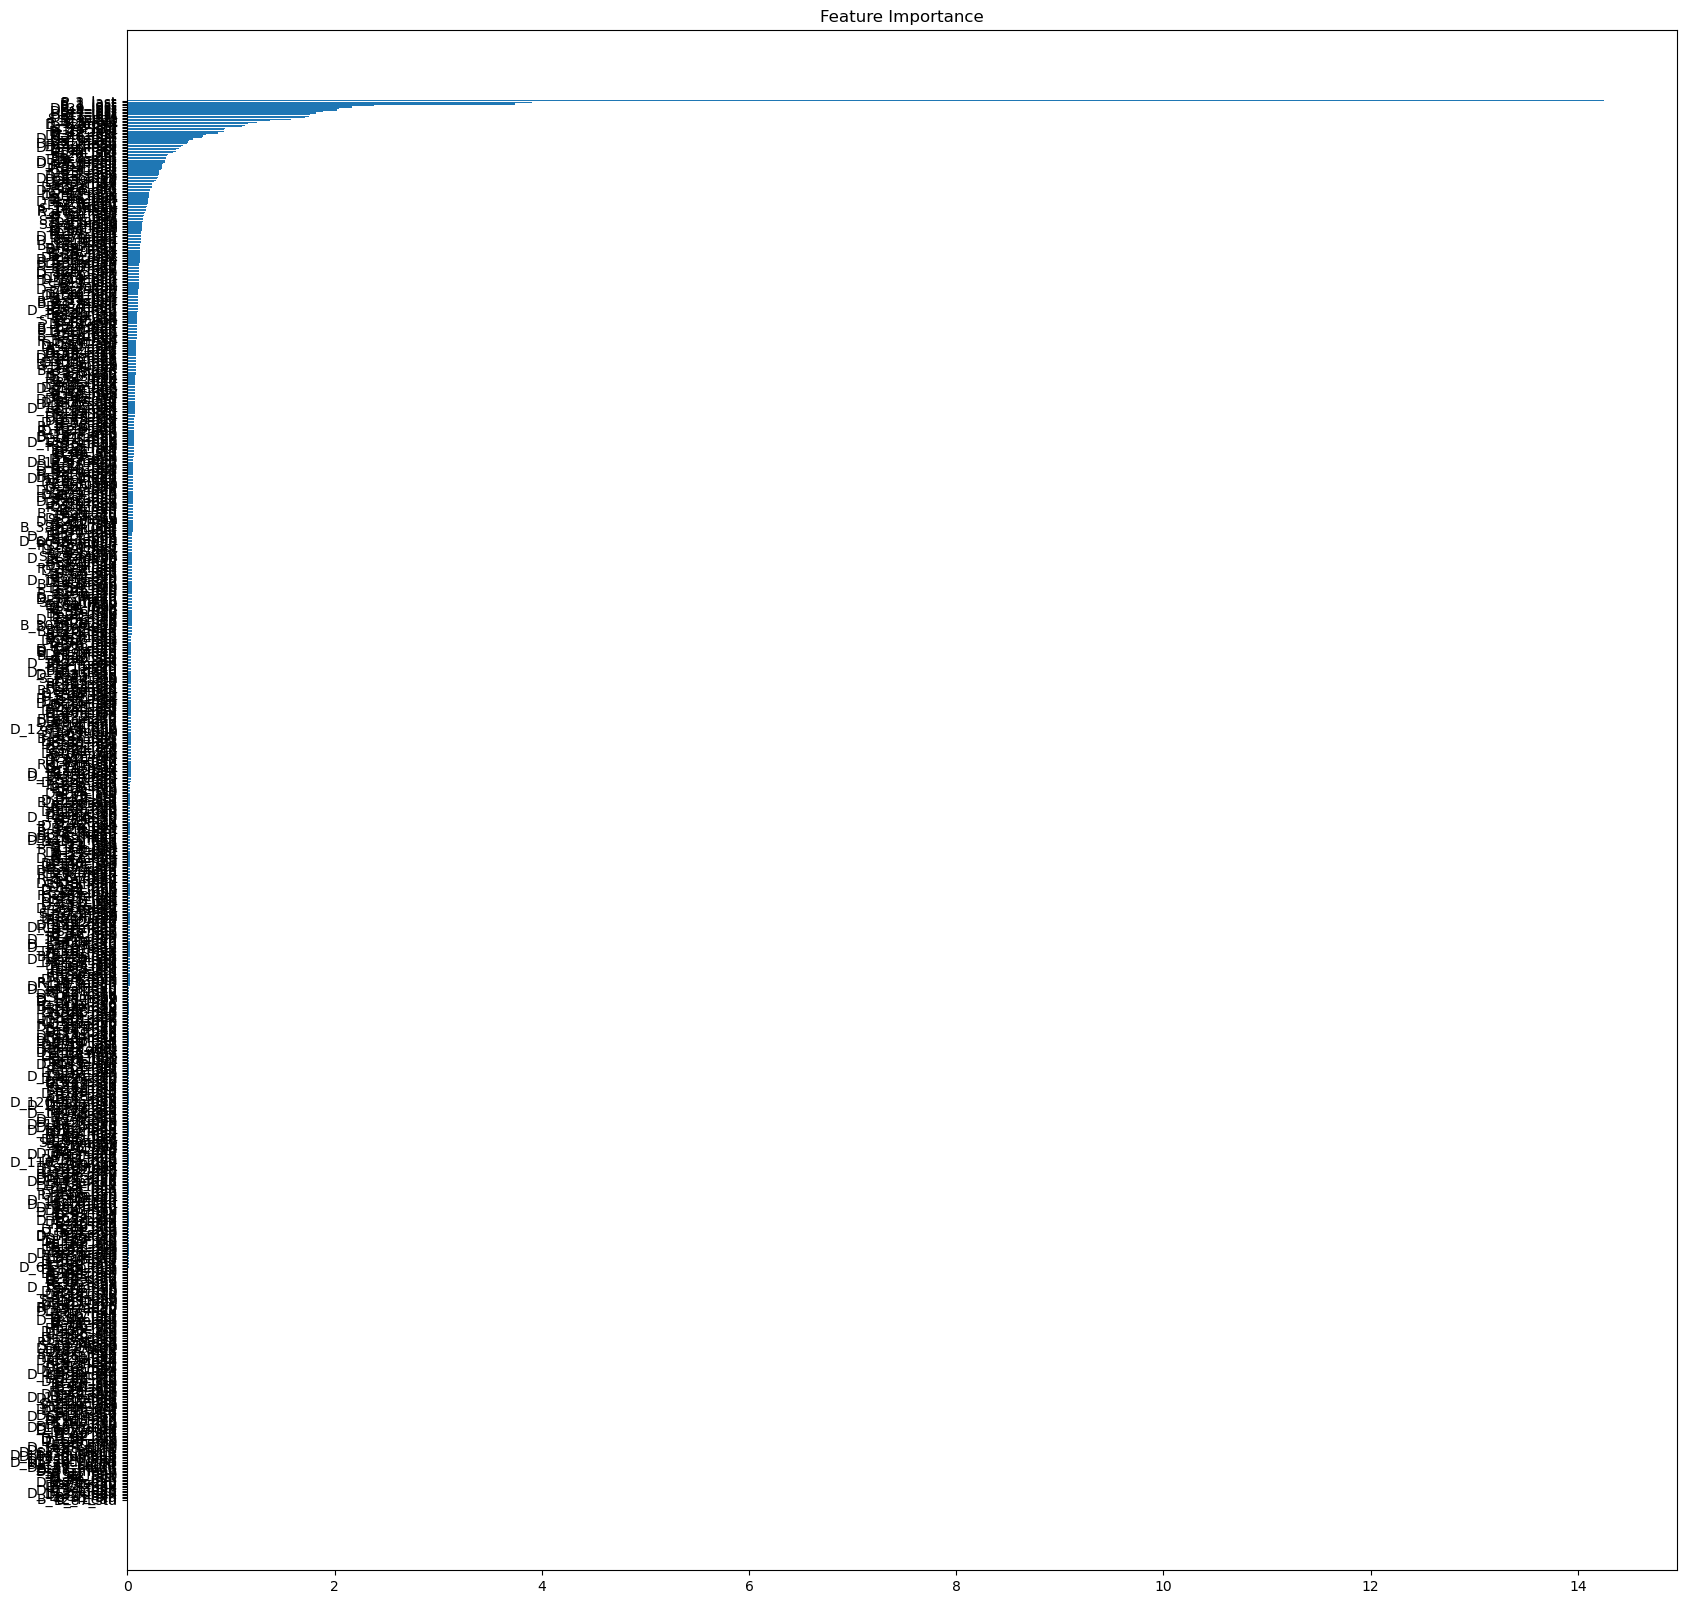

In [27]:
from matplotlib import pyplot as plt
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_data.columns)[sorted_idx])
plt.title('Feature Importance')
